In [3]:
# import libraries
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#from wordcloud import WordCloud
import re
import string
import nltk
import joblib
# Download the WordNet resource
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
# read data
df_train = pd.read_csv('twitter_training.csv')
df_val = pd.read_csv('twitter_validation.csv')
# concatenate data
df = pd.concat([df_train, df_val], ignore_index=False)
df.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,",3364,Facebook,Irrelevant,"I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣"
0,2401.0,Borderlands,Positive,I am coming to the borders and I will kill you...,NaN,NaN,NaN,NaN
1,2401.0,Borderlands,Positive,im getting on borderlands and i will kill you ...,NaN,NaN,NaN,NaN
2,2401.0,Borderlands,Positive,im coming on borderlands and i will murder you...,NaN,NaN,NaN,NaN
3,2401.0,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,NaN,NaN,NaN,NaN
4,2401.0,Borderlands,Positive,im getting into borderlands and i can murder y...,NaN,NaN,NaN,NaN


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 75680 entries, 0 to 998
Data columns (total 8 columns):
 #   Column                                                                                                                                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                                                                                                                                              --------------  -----  
 0   2401                                                                                                                                                                                                                                                74681 non-null  float64
 1   Borderlands                                                                

In [12]:
# Remove unnecessary columns
columns_to_drop = ['2401', '3364', 'Facebook', 'Irrelevant',
                   'I mentioned on Facebook that I was struggling for motivation to go for a run the other day, which has been translated by Tom’s great auntie as ‘Hayley can’t get out of bed’ and told to his grandma, who now thinks I’m a lazy, terrible person 🤣']
df = df.drop(columns_to_drop, axis=1)

# Rename columns
df = df.rename(columns={'im getting on borderlands and i will murder you all ,': 'Tweet', 'Positive': 'Sentiment', 'Borderlands':"Branch"})
df.head()

,Branch,Sentiment,Tweet
0,Borderlands,Positive,I am coming to the borders and I will kill you...
1,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,Borderlands,Positive,im coming on borderlands and i will murder you...
3,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,Borderlands,Positive,im getting into borderlands and i can murder y...


In [13]:
# check missing values
print(df.isnull().sum())

Branch        999
Sentiment     999
Tweet        1685
dtype: int64


In [14]:
# remove missing values
df.dropna(inplace=True)
# check missing values
df.isnull().sum()   

Branch       0
Sentiment    0
Tweet        0
dtype: int64

In [15]:
# check duplicate values
df.duplicated().sum()

3038

In [16]:
# remove duplicate values 
remove_duplicates = df.drop_duplicates()
df = remove_duplicates
# check duplicate values
df.duplicated().sum()

0

### Preprocessing The Data

In [17]:
#Remove Non-String
def filter_non_string(df, column):
    """
    Filter out rows with non-string values in the specified column.
    Convert non-string values to strings.
    """
    df = df.dropna(subset=[column])
    df[column] = df[column].astype(str)
    return df

In [18]:
 #Convert In LowerCase
def normalize_text(text):
    """Convert text to lowercase to ensure consistency across the corpus."""
    return text.lower()    

In [20]:
#Remove HTML Tags
def remove_html_tags(text):
    """Remove HTML tags from the text."""
    return re.sub(r'<.*?>', '', text)

In [19]:
#Remove URL Or HyperLink
def remove_urls(text):
    """Remove URLs or hyperlinks from the text."""
    return re.sub(r'http\S+|www\S+', '', text)

In [21]:
#Remove Numeric Digit
def remove_numbers(text):
    """Exclude numerical digits from the text."""
    return re.sub(r'\d+', '', text)

In [22]:
#Remove Punctuation
def remove_punctuation(text):
    """Remove punctuation marks from the text."""
    return text.translate(str.maketrans('', '', string.punctuation))

In [23]:
#Split Text In Token
def tokenize_text(text):
    """Split the text into individual words or tokens."""
    return word_tokenize(text)

In [24]:
#Eliminate Stopwords
def remove_stopwords(tokens):
    """Eliminate common stopwords from the tokenized text."""
    stop_words = set(stopwords.words('english'))
    return [word for word in tokens if word not in stop_words]

In [25]:
#Remove Emojis
import re

def remove_emojis(text):
    """Remove emojis from the text."""
    if isinstance(text, str):
        emoji_pattern = re.compile("["
                                   u"\U0001F600-\U0001F64F"  # emoticons
                                   u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                   u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                   u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                   u"\U00002500-\U00002BEF"  # chinese char
                                   u"\U00002702-\U000027B0"
                                   u"\U00002702-\U000027B0"
                                   u"\U000024C2-\U0001F251"
                                   u"\U0001f926-\U0001f937"
                                   u"\U00010000-\U0010ffff"
                                   u"\u2640-\u2642"
                                   u"\u2600-\u2B55"
                                   u"\u200d"
                                   u"\u23cf"
                                   u"\u23e9"
                                   u"\u231a"
                                   u"\ufe0f"  # dingbats
                                   u"\u3030"
                                   "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    else:
        return text

In [26]:
#Vectorize Data
def vectorize_data(text_data):
    # Join the tokenized text into strings
    text_data_strings = [" ".join(tokens) for tokens in text_data]
    # Initialize TfidfVectorizer
    tfidf_vectorizer = TfidfVectorizer()
    # Fit and transform the text data to generate TF-IDF vectors
    tfidf_vectors = tfidf_vectorizer.fit_transform(text_data_strings)
    return tfidf_vectors, tfidf_vectorizer

In [27]:
def preprocess_text(df):
    df = filter_non_string(df, 'Tweet')
    df['Tweet'] = df['Tweet'].apply(normalize_text)
    df['Tweet'] = df['Tweet'].apply(remove_html_tags)
    df['Tweet'] = df['Tweet'].apply(remove_urls)
    df['Tweet'] = df['Tweet'].apply(remove_numbers)
    df['Tweet'] = df['Tweet'].apply(remove_punctuation)
    df['Tweet'] = df['Tweet'].apply(tokenize_text)
    df['Tweet'] = df['Tweet'].apply(remove_stopwords)
    df['Tweet'] = df['Tweet'].apply(remove_emojis)
    return df

# Usage:
df_processed = preprocess_text(df)

In [28]:
df_processed

,Branch,Sentiment,Tweet
0,Borderlands,Positive,"[coming, borders, kill]"
1,Borderlands,Positive,"[im, getting, borderlands, kill]"
2,Borderlands,Positive,"[im, coming, borderlands, murder]"
3,Borderlands,Positive,"[im, getting, borderlands, murder]"
4,Borderlands,Positive,"[im, getting, borderlands, murder]"
...,...,...,...
74676,Nvidia,Positive,"[realized, windows, partition, mac, like, year..."
74677,Nvidia,Positive,"[realized, mac, window, partition, years, behi..."
74678,Nvidia,Positive,"[realized, windows, partition, mac, years, beh..."
74679,Nvidia,Positive,"[realized, windows, partition, mac, like, year..."


### Build Model

In [29]:
#Train Split Data
df_processed['Tweet'] = df_processed['Tweet'].apply(lambda x: ' '.join(x))

# Split data into features (X) and target (y)
X = df_processed['Tweet']  # Features
y = df_processed['Sentiment']  # Target

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the training and testing sets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (56765,)
Shape of X_test: (14192,)
Shape of y_train: (56765,)
Shape of y_test: (14192,)


In [30]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_tfidf, y_train)

# Predict on the testing data
y_pred = rf_classifier.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy:", accuracy)

Test Accuracy: 0.9062147688838782


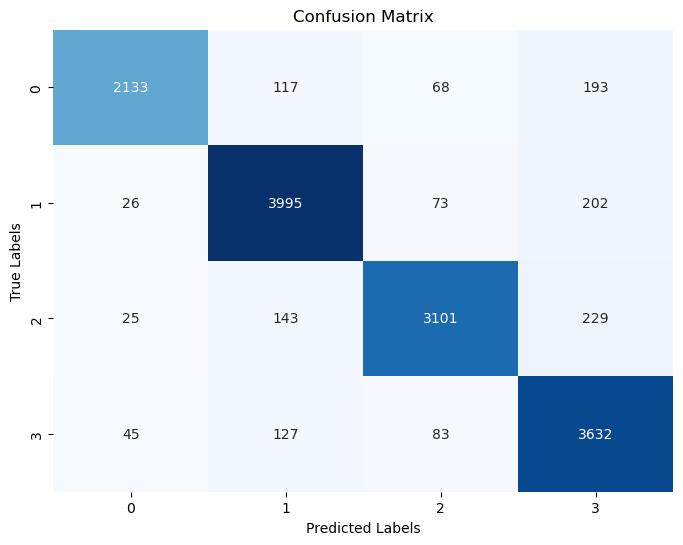

Classification Report:
              precision    recall  f1-score   support

  Irrelevant       0.96      0.85      0.90      2511
    Negative       0.91      0.93      0.92      4296
     Neutral       0.93      0.89      0.91      3498
    Positive       0.85      0.93      0.89      3887

    accuracy                           0.91     14192
   macro avg       0.91      0.90      0.91     14192
weighted avg       0.91      0.91      0.91     14192



In [31]:
# Create a confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a classification report
class_report = classification_report(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print classification report
print("Classification Report:")
print(class_report)